# Using astropy: fits files, Table, SkyCoord and units

## Introduction
Here we are trying to get familiar with astropy. In particular, we are going to look into Tables which are really a building block for gammapy.

We will:
- open and write fits files with [io.fits](http://docs.astropy.org/en/stable/io/fits/index.html)
- manipulate [coordinates](http://docs.astropy.org/en/stable/coordinates/): [SkyCoord](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html)  and [Angle](http://docs.astropy.org/en/stable/coordinates/angles.html) classes
- use [units](http://docs.astropy.org/en/stable/units/index.html) and [Quantities](http://docs.astropy.org/en/stable/api/astropy.units.Quantity.html). See also this [tutorial](http://www.astropy.org/astropy-tutorials/Quantities.html)
- manipulate [Times and Dates](http://docs.astropy.org/en/stable/time/index.html)
- use [tables](http://docs.astropy.org/en/stable/table/index.html) with the [Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html) class with the Fermi catalog
- define regions in the sky with the [region](http://astropy-regions.readthedocs.io/en/latest/getting_started.html) package

In [39]:
# to make plots appear in the notebook
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Units, Quantities and constants
import astropy.units as u
from astropy.units import Quantity
import astropy.constants as cst

# Table
from astropy.table import Table

# Coordinates
from astropy.coordinates import SkyCoord, Angle

# Time
from astropy.time import Time
# FITS I/O
from astropy.io import fits 


## Units and constants

### Basic usage

In [40]:
# One can create a Quantity like this
L = Quantity(1e35,unit='erg/s')
# or like this
d = 8 * u.kpc

# then one can produce new Quantities
flux = L/(4*np.pi*d**2)

# And convert its value to any (homogeneous) unit
print(flux.to('erg cm**-2 s**-1'))
print(flux.to('W/m**2'))
# print(flux.to('Ci')) would raise a UnitConversionError


1.30589744313e-11 erg / (cm2 s)
1.30589744313e-14 W / m2


More generally a Quantity is a numpy array with a unit.

In [41]:
E = np.logspace(1,4,10)*u.GeV
print(E.to('TeV'))

[  0.01         0.02154435   0.04641589   0.1          0.21544347
   0.46415888   1.           2.15443469   4.64158883  10.        ] TeV


Here we compute the interaction time of protons.

In [42]:
x_eff = 30 * u.mbarn
density = 1 * u.cm**-3

interaction_time = (density * x_eff * cst.c)**-1

interaction_time.to('Myr')

<Quantity 35.23336113415385 Myr>

### Use Quantities in functions. 

We compute here the energy loss rate of an electron of kinetic energy E in magnetic field B. See formula (5B10) in this [lecture](http://www.cv.nrao.edu/course/astr534/SynchrotronPower.html)


4.05193281315e-13 erg / s


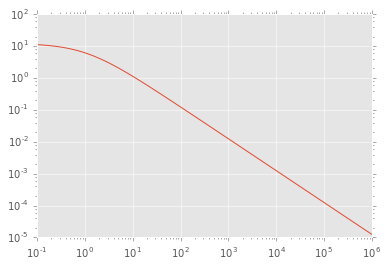

In [43]:
def electron_energy_loss_rate(B, E):
    """ energy loss rate of an electron of kinetic energy E in magnetic field B
    """
    U_B = B**2/(2*cst.mu0)
    gamma = E/(cst.m_e*cst.c**2) + 1   # note that this works only because E/(cst.m_e*cst.c**2) is dimensionless
    beta = np.sqrt(1-1/gamma**2)
    return 4./3.* cst.sigma_T * cst.c * gamma**2 * beta**2 * U_B

print(electron_energy_loss_rate(1e-5*u.G,1*u.TeV).to('erg/s'))

# Now plot it
E_elec = np.logspace(-1.,6,100)*u.MeV
B = 1 * u.G
plt.loglog(E_elec,(E_elec/electron_energy_loss_rate(B,E_elec)).to('yr'))

A frequent issue is homogeneity. One can use decorators to ensure it.

In [44]:
# This ensures that B and E are homogeneous to magnetic field strength and energy
# If not will raise a UnitError exception
@u.quantity_input(B=u.T,E=u.J)     
def electron_energy_loss_rate(B, E):
    """ energy loss rate of an electron of kinetic energy E in magnetic field B
    """
    U_B = B**2/(2*cst.mu0)
    gamma = E/(cst.m_e*cst.c**2) + 1   # note that this works only because E/(cst.m_e*cst.c**2) is dimensionless
    beta = np.sqrt(1-1/gamma**2)
    return 4./3.* cst.sigma_T * cst.c * gamma**2 * beta**2 * U_B

# Now try it
try:
    print(electron_energy_loss_rate(1e-5*u.G,1*u.Hz).to('erg/s'))
except u.UnitsError, message:
    print('Incorrect unit: '+ str(message))


Incorrect unit: Argument 'E' to function 'electron_energy_loss_rate' must be in units convertible to 'J'.


## Coordinates

Note that SkyCoord are arrays of coordinates. We will see that in more detail in the next section.

In [45]:
# Different ways to create a SkyCoord
c1 = SkyCoord(10.625, 41.2, frame='icrs', unit='deg')
c1 = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')

c2 = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# c2 = SkyCoord.from_name("Crab")     # Get the name from CDS

print(c1.ra,c2.dec)

print('Distance to Crab: ',c1.separation(c2))    # separation returns an Angle object
print('Distance to Crab: ',c1.separation(c2).degree)

(<Longitude 10.624999999999998 deg>, <Latitude 22.0145 deg>)
('Distance to Crab: ', <Angle 63.2078415848386 deg>)
('Distance to Crab: ', 63.2078415848386)


### Coordinates transformation

How to change between coordinate frames. The Crab in Galactic coordinates.

In [46]:
c2b = c2.galactic
print(c2b)
print(c2b.l,c2b.b)

<SkyCoord (Galactic): (l, b) in deg
    (184.55745771, -5.78435696)>
(<Longitude 184.5574577123824 deg>, <Latitude -5.784356964188561 deg>)


## Time 

Is the Crab visible now?

In [47]:
now = Time.now()
print(now)
print(now.mjd)

2017-02-17 14:40:20.527568
57801.6113487


In [48]:
# define the location for the AltAz system
from astropy.coordinates import EarthLocation, AltAz
paris = EarthLocation( lat=48.8567*u.deg, lon=2.3508*u.deg )
 
# calculate the horizontal coordinates 
crab_altaz = c2.transform_to( AltAz( obstime=now, location=paris ))

print(crab_altaz)

<SkyCoord (AltAz: obstime=2017-02-17 14:40:20.527568, location=(4200910.643257838, 172456.78503911156, 4780088.658775934) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    (86.74224431, 26.98012919)>


## Table: Manipulating the 3FGL catalog

Here we are going to do some selections with the 3FGL catalog. To do so we use the Table class from astropy.

### Accessing the table
First, we need to open the catalog in a Table. 

In [49]:
# Open Fermi 3FGL from the repo
table = Table.read("$GAMMAPY_EXTRA/datasets/catalogs/fermi/gll_psc_v16.fit.gz")
# Alternatively, one can grab it from the server.
#table = Table.read("http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v16.fit")

In [50]:
# Note that a single fits file might contain different tables in different HDUs
from astropy.io import fits
fits.open("$GAMMAPY_EXTRA/datasets/catalogs/fermi/gll_psc_v16.fit.gz").info()
extended_source_table = Table.read("$GAMMAPY_EXTRA/datasets/catalogs/fermi/gll_psc_v16.fit.gz",
                                   hdu='ExtendedSources')

IOError: [Errno 2] No such file or directory: '$GAMMAPY_EXTRA/datasets/catalogs/fermi/gll_psc_v16.fit.gz'

### General informations on the Table


In [ ]:
table.info

In [ ]:
# Statistics on each column
table.info('stats')

In [ ]:
### list of column names
table.colnames

In [ ]:
# HTML display
table.show_in_browser(jsviewer=True)
#table.show_in_notebook(jsviewer=True)

### Accessing the table

In [ ]:
# The header keywords are stored as a dict
# print table.meta
table.meta['TSMIN']

In [ ]:
# First row
table[0]

In [ ]:
# Spectral index of the 10 first entries
table[:10]['Spectral_Index']

In [ ]:
# Which source has the lowest spectral index?
min_index_row = table[np.argmin(table['Spectral_Index'])]
print('Hardest source: ',min_index_row['Source_Name'], 
                         min_index_row['CLASS1'],min_index_row['Spectral_Index'])

# Which source has the largest spectral index?
max_index_row = table[np.argmax(table['Spectral_Index'])]
print('Softest source: ',max_index_row['Source_Name'], 
                         max_index_row['CLASS1'],max_index_row['Spectral_Index'])



### Quantities and SkyCoords from a Table

In [ ]:
fluxes = table['nuFnu1000_3000'].quantity
print(fluxes)
coord = SkyCoord(table['GLON'],table['GLAT'],frame='galactic')
print(coord.fk5)

### Selections in a Table

Here we select Sources according to their class and do some whole sky chart

In [ ]:
# Get coordinates of FSRQs
fsrq = np.where( np.logical_or(table['CLASS1']=='fsrq ',table['CLASS1']=='FSQR '))


In [ ]:
# This is here for plotting purpose...
#glon = glon.wrap_at(180*u.degree)

# Open figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(coord[fsrq].l.wrap_at(180*u.degree).radian, 
           coord[fsrq].b.radian, 
           color = 'k', label='FSRQ')
ax.grid(True)
ax.legend()
# ax.invert_xaxis()  -> This does not work for projections...  

In [ ]:
### Now do it for a series of classes
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="aitoff")

### The list of object types. 
class_list = ['     ','psr  ','spp  ', 'fsrq ', 'bll  ', 'bin  ']
### The colors used for the plot
color_list = ['k', 'b', 'g', 'y', 'r','c']

### We use enumerate which gives us an iterator and its index in the collection
for cl,col in zip(class_list,color_list):
    print cl
    ### We select elements wiht correct class in upper or lower characters
    index = np.where(np.logical_or(table['CLASS1']==cl,
                                   table['CLASS1']==cl.upper()))
    
    ax.scatter(coord[index].l.wrap_at(180*u.degree).radian, 
               coord[index].b.radian,
               label=cl.upper(), color=col)


ax.grid(True)
ax.legend()




## Using regions

Let's try to find sources inside a circular region in the sky.

For this we will rely on the [region package](http://astropy-regions.readthedocs.io/en/latest/index.html)

We first create a circular region centered on a given SkyCoord with a given radius.

In [ ]:
from regions import CircleSkyRegion

circle_region = CircleSkyRegion(
    center=SkyCoord.from_name("M31"),
    radius=Angle(50, 'deg')
)

We now use the contains method to search objects in this circular region in the sky.

In [ ]:
in_region = circle_region.contains(coord)

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(coord[in_region].l.radian, coord[in_region].b.radian)


### Tables and panda

TODO


## Exercices

- When searched for the hardest and softest sources in 3FGL we did not look at the type of spectrum (PL, ECPL etc), find the hardest and softest PL sources instead. 
- Replot the full sky chart of sources in ra-dec instead of galactic coordinates
- Find the 3FGL sources visible from Paris now